##  Self Adaptive Multiwavelet Neural Operator 
### Key improvements: 
In our SAMWO model, the key improvements compared to our baseline model MWO(Gupta,et al 2021) are: </br>
*  SAMWO is much more faster than MWO. For the case of 1d KDV equation, with 500 epoch training we achieved approximatedly 1000s for SAMWO but 1300s for MWO, which is almost 24% faster.
*  SAMWO has better accuracy(l2 norm) than that of MWO. It achieved l2 error of 0.00257 where MWO achieved 0.00511.
*  This adequately outperforms the FNO, which is known to have achieved the l2 error of 0.0126, in the same hyper-parameter setting(with the same data-set, obviously).
*  SAMWO tends to balance between the spectral bias problem; the model itself tries to select better weight to be applied for higher and lower frequency respectively in each scales.

### Key mechanisms:
We tried to:
*  Kept our baseline structure to that of the non-standard wavelet representation
*  Used different learning networks for coarse/finer scales respectively
*  In the case of coarse scale, we downsized the number of loops for the decomposition in order to sped up the training and at the same time to reduce the model to observe at too low resolution
*  To compensate the above layer cut-down, in the finer scales we additionally gave self-learnable weights over the high/low frequency coefficients in each scale so that the model can learn and decide which level of frequency is more important
*  For example, the learnt weight was given by 0.58, 0.48, 0.56, 0.48, 0.53 at the end of training(first layer, high-frequency). This reveals that it was necessary to give a bit higher attention to the high-frequency part of the data. Recall the spectral bias problem; the neural network tends to learn from the lower frequency first! 
*  However strikingly, while learning in high fluctuation data, the learnt weight tends to decrease. Since learning more in the high frequency over such domain may cause over-fitting, we may think that the model itself tries adaptively to learn more stably.

### Mathematical formulation of the network:
Our Self-Selective MWO has following wavelet representation of the operator kernel $K$:
$$ T_n = \sum_{\text{coarse,k= h..., (h-L)/k'}} [(A_k^{'} d_l^k +B_k^{'} s_l^k) +(C_k^{'} d_l^k)] + \bar{T}s_l^L  + \sum_{\text{finer},k=n,n-1,..h} [w_k \otimes [(A_k d_l^k +B_k s_l^k)] + (1-w_k) \otimes (C_k d_l^k)] $$
where $w_k$ are learnable parameters given by $w_k = \text{sigmoid}(W_k)$ and $W_k$ is the attention matrix. Here $h,k'$ are pre-assigned hyperparameters(Usually selected that $h=n/2$ and $k'=4$ )

### Some drawbacks:
*  This model is not very much owning to novel, theoritically rigorous based approach
*  Could not find appropriate FDMT(Fast-discrete multiwavelet transform) algorithm applicable for the non-standard wavelet representation. However, using of different matrix filter may be useful later(sparse or some approximates of it)

### Comments:
*  There is a similar named paper called Multilevel Attention wavelet operator(AAAI 2024, accepted but yet to be published). But authors found this paper only when we finised deciding our idea.
*  Moreover, the above paper do not use the baseline architecture of MWT but the WNO(2023), so the model architecture is very disparate from that of ours. Also, they do not have adaptive structure but only giving attention over detailed coefficients. So we are confident that our model has novel structure compared to other existing models.
*  Also, both the papers have no mention over the spectral bias and corresponding analysis, whereas we empirically provide the model's stength toward such bias problems.

### Further research topics:
*  We can make a comparison study between the various matrix filters and introduce a faster matrix multiplication alogirhithm to enhance the multiwavelet transformation
*  Actually, we found that using more memory, easy operation involving block matrix multiplication yielded much faster transformation time.  But not included in our case yet
*  Since our model captures fluctuations faster, this can be further applied to problems with stiff boundary condition.   

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import List, Tuple
import math
from scipy.io import loadmat, savemat
import os
import h5py
from functools import partial
from models.utils import train, test, LpLoss, get_filter, UnitGaussianNormalizer
import matplotlib.pyplot as plt
from scipy.signal import periodogram

In [ ]:
# This ipynb file learns the burgers equation
# So the outputs may be little different with above
# Experiment is carried out over:
# GPU: Geforce RTX 4060ti
# Python version: 3.9.18
# Cuda version: 12.3
# Pytorch version : 2.2.1

In [2]:
# Model
class sparseKernel1d(nn.Module):
    def __init__(self,
                 k, alpha, c=1,
                 nl = 1,
                 initializer = None,
                 **kwargs):
        super(sparseKernel1d,self).__init__()

        self.k = k
        self.Li = nn.Linear(c*k, 128)
        self.conv = self.convBlock(c*k, 128)
        self.Lo = nn.Linear(128, c*k)

    def forward(self, x):
        B, N, c, ich = x.shape # (B, N, c, k)
        x = x.view(B, N, -1)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        x = self.Lo(x)
        x = x.view(B, N, c, ich)
        return x


    def convBlock(self, ich, och):
        net = nn.Sequential(
            nn.Conv1d(ich, och, 3, 1, 1),
            nn.ReLU(inplace=True),
        )
        return net

def compl_mul1d(x, weights):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    return torch.einsum("bix,iox->box", x, weights)

class sparseKernelFT1d(nn.Module):
    def __init__(self,
                 k, alpha, c=1,
                 nl = 1,
                 initializer = None,
                 **kwargs):
        super(sparseKernelFT1d, self).__init__()

        self.modes1 = alpha
        self.scale = (1 / (c*k*c*k))
        self.weights1 = nn.Parameter(self.scale * torch.rand(c*k, c*k, self.modes1, dtype=torch.cfloat))
        self.weights1.requires_grad = True
        self.k = k

    def forward(self, x):
        B, N, c, k = x.shape # (B, N, c, k)

        x = x.view(B, N, -1)
        x = x.permute(0, 2, 1)
        x_fft = torch.fft.rfft(x)
        # Multiply relevant Fourier modes
        l = min(self.modes1, N//2+1)
        out_ft = torch.zeros(B, c*k, N//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :l] = compl_mul1d(x_fft[:, :, :l], self.weights1[:, :, :l])

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=N)
        x = x.permute(0, 2, 1).view(B, N, c, k)
        return x

class MWT_CZ1d_multi(nn.Module):
    def __init__(self,
                 k = 3, alpha = 5,
                 L = 0, c = 1,
                 base = 'legendre',
                 initializer = None,
                 **kwargs
                 ):
        super(MWT_CZ1d_multi, self).__init__()

        self.k = k
        self.L = L
        H0, H1, G0, G1, PHI0, PHI1 = get_filter(base, k)
        H0r = H0@PHI0
        G0r = G0@PHI0
        H1r = H1@PHI1
        G1r = G1@PHI1

        H0r[np.abs(H0r)<1e-8]=0
        H1r[np.abs(H1r)<1e-8]=0
        G0r[np.abs(G0r)<1e-8]=0
        G1r[np.abs(G1r)<1e-8]=0

        #self.A = sparseKernel1d(k, alpha, c)
        #self.B = sparseKernel1d(k, alpha, c)
        #self.C = sparseKernel1d(k, alpha, c)
        self.W = nn.Linear(k,k)

        self.A_low = sparseKernelFT1d(k, alpha, c)
        self.B_low = sparseKernelFT1d(k, alpha, c)
        self.C_low = sparseKernelFT1d(k, alpha, c)


        self.T0 = nn.Linear(k, k)

        self.register_buffer('ec_s', torch.Tensor(
            np.concatenate((H0.T, H1.T), axis=0)))
        self.register_buffer('ec_d', torch.Tensor(
            np.concatenate((G0.T, G1.T), axis=0)))

        self.register_buffer('rc_e', torch.Tensor(
            np.concatenate((H0r, G0r), axis=0)))
        self.register_buffer('rc_o', torch.Tensor(
            np.concatenate((H1r, G1r), axis=0)))
        


        initial_lambda = 0.5
        self.attention = nn.ParameterList(
            [nn.Parameter(torch.tensor(initial_lambda)) for _ in range((math.floor(np.log2(1024))-self.L)//2)] 
        )


    def forward(self, x):

        B, N, c, ich = x.shape # (B, N, k)
        ns = math.floor(np.log2(N))

        Ud = torch.jit.annotate(List[Tensor], [])
        Us = torch.jit.annotate(List[Tensor], [])
        
#         decompose
        for i in range((ns-self.L)//2):
            d, x = self.wavelet_transform(x)
            temp_z = self.C_low(d)

            ### before ###
            #Ud += [self.A_low(d) + self.B_low(x)]
            #Us += [temp_z]

            ### after ###
            lam = F.sigmoid(self.attention[i])
            Ud += [lam*(self.A_low(d) + self.B_low(x))]
            Us += [(1-lam)*temp_z]

            
        for i in range((ns-self.L)//4):
            d, x = self.wavelet_transform(x)
            ### after ###
            temp_y = self.C_low(d)
            Ud += [self.A_low(d) + self.B_low(x)]
            Us += [temp_y]

        x = self.T0(x) # coarsest scale transform

#        reconstruct
        for i in range((ns-self.L)//4+(ns-self.L)//2-1,-1,-1):
            #for i in range((ns-self.L)//4+(ns-self.L)//2-1,-1,-1):
            x = x + Us[i]
            x = torch.cat((x, Ud[i]), -1)
            x = self.evenOdd(x)
        return x

    def wavelet_transform(self, x):
        xa = torch.cat([x[:, ::2, :, :],
                        x[:, 1::2, :, :],
                       ], -1)
        d = torch.matmul(xa, self.ec_d)
        s = torch.matmul(xa, self.ec_s)
        return d, s

    def evenOdd(self, x):

        B, N, c, ich = x.shape # (B, ,N c, k)
        assert ich == 2*self.k
        x_e = torch.matmul(x, self.rc_e)
        x_o = torch.matmul(x, self.rc_o)

        x = torch.zeros(B, N*2, c, self.k,
            device = x.device)
        x[..., ::2, :, :] = x_e
        x[..., 1::2, :, :] = x_o
        return x

# new
class MWT1d_multi(nn.Module):
    def __init__(self,
                 ich = 1, k = 3, alpha = 2, c = 1,
                 nCZ = 3,
                 L = 0,
                 base = 'legendre',
                 initializer = None,
                 **kwargs):
        super(MWT1d_multi,self).__init__()

        self.k = k
        self.c = c
        self.L = L
        self.nCZ = nCZ
        self.Lk = nn.Linear(ich, c*k)

        self.MWT_CZ = nn.ModuleList(
            [MWT_CZ1d_multi(k, alpha, L, c, base,
            initializer) for _ in range(nCZ)]
        )
        self.Lc0 = nn.Linear(c*k, 128)
        self.Lc1 = nn.Linear(128, 1)

        if initializer is not None:
            self.reset_parameters(initializer)

    def forward(self, x):

        B, N, ich = x.shape # (B, N, d)
        ns = math.floor(np.log2(N))
        x = self.Lk(x)
        x = x.view(B, N, self.c, self.k)

        for i in range(self.nCZ):
            x = self.MWT_CZ[i](x)
            if i < self.nCZ-1:
                x = F.relu(x)

        x = x.view(B, N, -1) # collapse c and k
        x = self.Lc0(x)
        x = F.relu(x)
        x = self.Lc1(x)
        return x.squeeze()

    def reset_parameters(self, initializer):
        initializer(self.Lc0.weight)
        initializer(self.Lc1.weight)


##############################################################
### original ##############################################

class MWT_CZ1d(nn.Module):
    def __init__(self,
                 k = 3, alpha = 5,
                 L = 0, c = 1,
                 base = 'legendre',
                 initializer = None,
                 **kwargs):
        super(MWT_CZ1d, self).__init__()

        self.k = k
        self.L = L
        H0, H1, G0, G1, PHI0, PHI1 = get_filter(base, k)
        H0r = H0@PHI0
        G0r = G0@PHI0
        H1r = H1@PHI1
        G1r = G1@PHI1

        H0r[np.abs(H0r)<1e-8]=0
        H1r[np.abs(H1r)<1e-8]=0
        G0r[np.abs(G0r)<1e-8]=0
        G1r[np.abs(G1r)<1e-8]=0

        self.A = sparseKernelFT1d(k, alpha, c)
        self.B = sparseKernelFT1d(k, alpha, c)
        self.C = sparseKernelFT1d(k, alpha, c)

        self.T0 = nn.Linear(k, k)

        self.register_buffer('ec_s', torch.Tensor(
            np.concatenate((H0.T, H1.T), axis=0)))
        self.register_buffer('ec_d', torch.Tensor(
            np.concatenate((G0.T, G1.T), axis=0)))

        self.register_buffer('rc_e', torch.Tensor(
            np.concatenate((H0r, G0r), axis=0)))
        self.register_buffer('rc_o', torch.Tensor(
            np.concatenate((H1r, G1r), axis=0)))


    def forward(self, x):

        B, N, c, ich = x.shape # (B, N, k)
        ns = math.floor(np.log2(N))

        Ud = torch.jit.annotate(List[Tensor], [])
        Us = torch.jit.annotate(List[Tensor], [])
#         decompose
        for i in range(ns-self.L):
            d, x = self.wavelet_transform(x)
            Ud += [self.A(d) + self.B(x)]
            Us += [self.C(d)]
        x = self.T0(x) # coarsest scale transform

#        reconstruct
        for i in range(ns-1-self.L,-1,-1):
            x = x + Us[i]
            x = torch.cat((x, Ud[i]), -1)
            x = self.evenOdd(x)
        return x


    def wavelet_transform(self, x):
        xa = torch.cat([x[:, ::2, :, :],
                        x[:, 1::2, :, :],
                       ], -1)
        d = torch.matmul(xa, self.ec_d)
        s = torch.matmul(xa, self.ec_s)
        return d, s

    def evenOdd(self, x):

        B, N, c, ich = x.shape # (B, N, c, k)
        assert ich == 2*self.k
        x_e = torch.matmul(x, self.rc_e)
        x_o = torch.matmul(x, self.rc_o)

        x = torch.zeros(B, N*2, c, self.k,
            device = x.device)
        x[..., ::2, :, :] = x_e
        x[..., 1::2, :, :] = x_o
        return x

class MWT1d(nn.Module):
    def __init__(self,
                 ich = 1, k = 3, alpha = 2, c = 1,
                 nCZ = 3,
                 L = 0,
                 base = 'legendre',
                 initializer = None,
                 **kwargs):
        super(MWT1d,self).__init__()

        self.k = k
        self.c = c
        self.L = L
        self.nCZ = nCZ
        self.Lk = nn.Linear(ich, c*k)

        self.MWT_CZ = nn.ModuleList(
            [MWT_CZ1d(k, alpha, L, c, base,
            initializer) for _ in range(nCZ)]
        )
        self.Lc0 = nn.Linear(c*k, 128)
        self.Lc1 = nn.Linear(128, 1)

        if initializer is not None:
            self.reset_parameters(initializer)

    def forward(self, x):

        B, N, ich = x.shape # (B, N, d)
        ns = math.floor(np.log2(N))
        x = self.Lk(x)
        x = x.view(B, N, self.c, self.k)

        for i in range(self.nCZ):
            x = self.MWT_CZ[i](x)
            if i < self.nCZ-1:
                x = F.relu(x)

        x = x.view(B, N, -1) # collapse c and k
        x = self.Lc0(x)
        x = F.relu(x)
        x = self.Lc1(x)
        return x.squeeze()

    def reset_parameters(self, initializer):
        initializer(self.Lc0.weight)
        initializer(self.Lc1.weight)

In [3]:
torch.manual_seed(0)
np.random.seed(0)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_initializer(name):

    if name == 'xavier_normal':
        init_ = partial(nn.init.xavier_normal_)
    elif name == 'kaiming_uniform':
        init_ = partial(nn.init.kaiming_uniform_)
    elif name == 'kaiming_normal':
        init_ = partial(nn.init.kaiming_normal_)
    return init_

In [6]:
# Specify the parameters of interest
parameters_of_interest = ['MWT_CZ.0.attention.0','MWT_CZ.0.attention.1','MWT_CZ.0.attention.2','MWT_CZ.0.attention.3','MWT_CZ.0.attention.4']
parameters_of_interest += ['MWT_CZ.1.attention.0','MWT_CZ.1.attention.1','MWT_CZ.1.attention.2','MWT_CZ.1.attention.3','MWT_CZ.1.attention.4']

# Dictionary to store parameter values of interest
def attain_weight(model):
    param_history = {name: [] for name in parameters_of_interest}
    for name, param in model.named_parameters():
        if name in parameters_of_interest:
            param_history[name].append(param.clone().detach().cpu().numpy())
    array_list = list(param_history.values())
    get = [float(item[0]) for item in array_list] 
    get = list(np.mean(np.reshape(get, (2, -1)).T,axis=1))
    return get

In [5]:
####### For kdv equation
ntrain = 1000
ntest = 200

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h
batch_size = 20

rw_ = loadmat('kdv_train_test.mat')
x_data = rw_['input'].astype(np.float32)
y_data = rw_['output'].astype(np.float32)

x_train = x_data[:ntrain,::sub]
y_train = y_data[:ntrain,::sub]
x_test = x_data[-ntest:,::sub]
y_test = y_data[-ntest:,::sub]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

x_train = x_train.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [364]:
###### For burger equation
ntrain = 1000
ntest = 200

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h
batch_size = 40

rw_ = loadmat('burgers_data_R10.mat')
x_data = rw_['a'].astype(np.float32)
y_data = rw_['u'].astype(np.float32)

x_train = x_data[:ntrain,::sub]
y_train = y_data[:ntrain,::sub]
x_test = x_data[-ntest:,::sub]
y_test = y_data[-ntest:,::sub]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

x_train = x_train.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


In [7]:
###### For wave equation
ntrain = 1000
ntest = 200

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h
batch_size = 40

rw_ = np.load('wave_equation_dataset_2048_1024points.npz')
x_data = rw_['initial_conditions'].astype(np.float32)
y_data = rw_['final_conditions'].astype(np.float32)

x_train = x_data[:ntrain]
y_train = y_data[:ntrain]
x_test = x_data[-ntest:]
y_test = y_data[-ntest:]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

x_train = x_train.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [382]:
# Generate the test sample with pre-assigned frequencies
# For KdV, 2~20hz
# For Burgers, 5~50hz
# For wave, 1~10hz

sampling_freq = 1024  # Sampling frequency in Hz
signal_length = 1024  # Length of the signal
frequencies = np.arange(5,55,5)  # Frequencies from 5 Hz to 50 Hz in steps of 5 Hz

# Time vector
t = np.arange(signal_length) / sampling_freq

# Generate the signal
signal = np.zeros(signal_length)
for f in frequencies:
    signal += np.sin(2 * np.pi * f * t)

In [384]:
# Fourier transform and scaling
# Same set-up as in the spectral bias paper

def new_fft(yt):
    n = len(yt) # length of the signal
    k = np.arange(n)
    T = n/len(yt)
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range
    # -------------
    FFTYT = np.fft.fft(yt)/n # fft computing and normalization
    FFTYT = FFTYT[range(n//2)]
    fftyt = abs(FFTYT)
    return frq, fftyt

def pred_signal(model, signal):
    pred = model(torch.Tensor(signal.reshape(1,1024,1)).to(device)).detach().cpu()
    g, h= new_fft(pred)
    freq_selected = h[np.sum(g.reshape(-1, 1) == frequencies.reshape(1, -1), axis=-1, dtype='bool')]
    norm_dynamics = 2* freq_selected
    return norm_dynamics

# New model, SAMWO

In [391]:
# Intialization
ich = 1
initializer = get_initializer('xavier_normal') # xavier_normal, kaiming_normal, kaiming_uniform

model = MWT1d_multi(ich,
            alpha = 10,
            c = 4*4,
            k = 4,
            base = 'chebyshev', # legendre
            nCZ = 2,
            initializer = initializer,
            ).to(device)
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

In [392]:
# Train
import time as time
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
train_loss_traj = []
test_loss_traj = []
time_traj = []
to_ti = 0
param_list = [[0.5,0.5,0.5,0.5,0.5]]
freq_list = []

for epoch in range(1, epochs+1):

    # time, train loss
    tic = time.time()
    train_l2 = train(model, train_loader, optimizer, epoch, device,
        lossFn = myloss, lr_schedule = scheduler)
    toc = time.time()
    to_ti += toc-tic
    time_traj.append(to_ti)

    train_loss_traj.append(train_l2)

    # get the attention weight
    param_list.append(attain_weight(model))
    
    # get the frequency 
    freq_list.append(pred_signal(model,signal))

    # test loss
    test_l2 = test(model, test_loader, device, lossFn=myloss)
    test_loss_traj.append(test_l2)
    
    print(f'epoch: {epoch}, train l2 = {train_l2}, tr time = {toc-tic} test l2 = {test_l2}')
print(f'total time elapsed {to_ti}s')
    

epoch: 1, train l2 = 0.302956027507782, tr time = 1.28277587890625 test l2 = 0.09575432777404785
epoch: 2, train l2 = 0.07087787771224975, tr time = 1.1657683849334717 test l2 = 0.04861297190189361
epoch: 3, train l2 = 0.04805606925487518, tr time = 1.1464557647705078 test l2 = 0.04094458758831024
epoch: 4, train l2 = 0.04826978254318237, tr time = 1.1743087768554688 test l2 = 0.05002641379833221
epoch: 5, train l2 = 0.04164416599273681, tr time = 1.1357753276824951 test l2 = 0.034407454133033755
epoch: 6, train l2 = 0.03762174654006958, tr time = 1.170114278793335 test l2 = 0.04028034746646881
epoch: 7, train l2 = 0.03769418978691101, tr time = 1.1408634185791016 test l2 = 0.035535211563110354
epoch: 8, train l2 = 0.03228004950284958, tr time = 1.1656503677368164 test l2 = 0.029435208439826964
epoch: 9, train l2 = 0.037874720990657806, tr time = 1.1359944343566895 test l2 = 0.034704914093017576
epoch: 10, train l2 = 0.04503994083404541, tr time = 1.1336688995361328 test l2 = 0.0482647

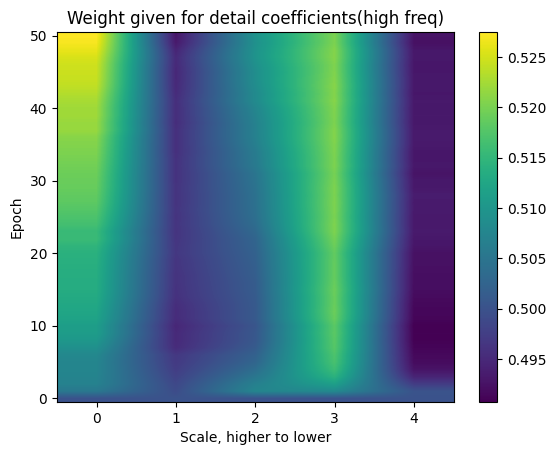

In [387]:
# Plot the weight parameter distribtuion
plt.imshow(param_list,origin='lower',interpolation='bilinear',aspect='auto')
plt.ylabel('Epoch')
plt.xlabel('Scale, higher to lower')
plt.title('Weight given for detail coefficients(high freq)')
plt.colorbar()

# Original model, MWO

In [393]:
# Intialization
ich = 1
initializer = get_initializer('xavier_normal') # xavier_normal, kaiming_normal, kaiming_uniform

model_org = MWT1d(ich,
            alpha = 10,
            c = 4*4,
            k = 4,
            base = 'chebyshev', # legendre
            nCZ = 2,
            initializer = initializer,
            ).to(device)
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

In [394]:
# Training
import time as time
optimizer = torch.optim.Adam(model_org.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
train_loss_traj_org = []
test_loss_traj_org = []
time_traj_org = []
to_ti = 0
freq_list_org = []

for epoch in range(1, epochs+1):
    tic = time.time()
    train_l2 = train(model_org, train_loader, optimizer, epoch, device,
        lossFn = myloss, lr_schedule = scheduler)
    toc = time.time()
    train_loss_traj_org.append(train_l2)
    to_ti += toc-tic
    time_traj_org.append(to_ti)
    
    # get the frequency 
    freq_list_org.append(pred_signal(model_org,signal))

    test_l2 = test(model_org, test_loader, device, lossFn=myloss)
    test_loss_traj_org.append(test_l2)
    print(f'epoch: {epoch}, train l2 = {train_l2}, tr time = {toc-tic} test l2 = {test_l2}')
print(f'total time elapsed {to_ti}s')

epoch: 1, train l2 = 0.3333472023010254, tr time = 1.6782102584838867 test l2 = 0.09834372639656067
epoch: 2, train l2 = 0.07884153699874878, tr time = 1.6627655029296875 test l2 = 0.08485394120216369
epoch: 3, train l2 = 0.07425999355316162, tr time = 1.671011209487915 test l2 = 0.054231094121932985
epoch: 4, train l2 = 0.049362504720687865, tr time = 1.4758720397949219 test l2 = 0.04197284460067749
epoch: 5, train l2 = 0.04105035650730133, tr time = 1.4395251274108887 test l2 = 0.03695550441741943
epoch: 6, train l2 = 0.04649850952625274, tr time = 1.4302890300750732 test l2 = 0.03438163340091705
epoch: 7, train l2 = 0.04073935842514038, tr time = 1.436250925064087 test l2 = 0.04665565967559814
epoch: 8, train l2 = 0.04868401646614075, tr time = 1.442495584487915 test l2 = 0.0447978276014328
epoch: 9, train l2 = 0.04791507279872894, tr time = 1.3980686664581299 test l2 = 0.06406936645507813
epoch: 10, train l2 = 0.05721620726585388, tr time = 1.4097611904144287 test l2 = 0.0569355618

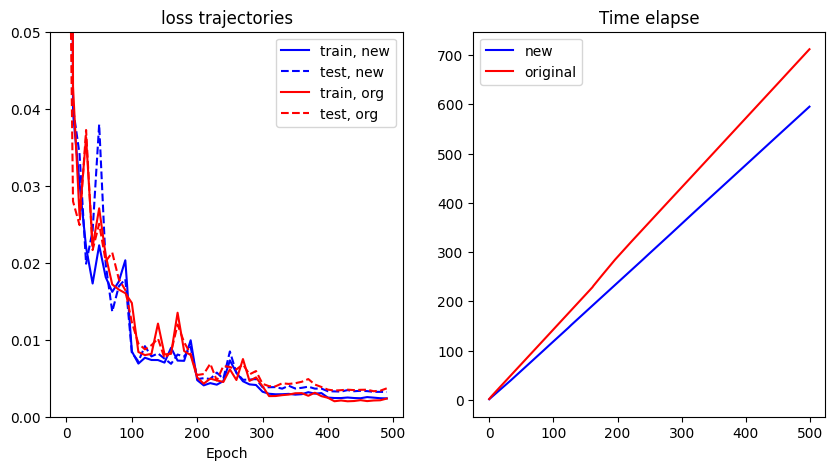

In [395]:
# Plot the loss trajectory and time curve
ind = [i for i in range(0,epoch,10)]

_, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
ax0.plot(ind,np.array(train_loss_traj)[ind], color='b', label = 'train, new')
ax0.plot(ind,np.array(test_loss_traj)[ind], '--',color='b', label = 'test, new')
ax0.plot(ind,np.array(train_loss_traj_org)[ind], color='r', label = 'train, org')
ax0.plot(ind,np.array(test_loss_traj_org)[ind], '--', color='r', label = 'test, org')
ax0.set_title('loss trajectories')
ax0.set_ylim(0,0.05)
ax0.set_xlabel("Epoch")

ax0.legend()

ax1.plot(time_traj, color='b', label = 'new')
ax1.plot(time_traj_org, color='r', label = 'original')
ax1.set_title('Time elapse')
ax0.set_xlabel("Epoch")
ax1.legend()

In [396]:
# Prediction of test set
mwt_new = model(x_test.to(device))
mwt_org = model_org(x_test.to(device))

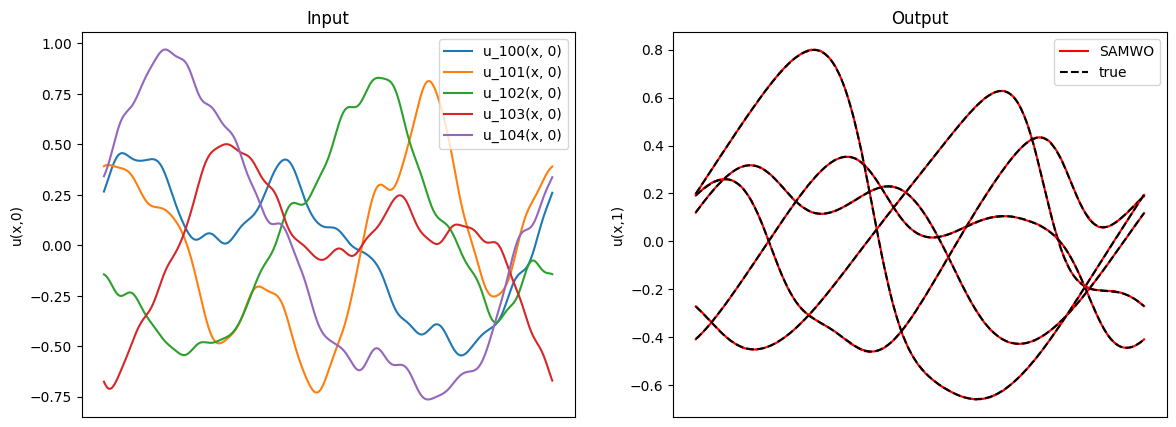

In [397]:
# Plot the profile curve, left for inputs and right for outputs
_, (ax0, ax1) = plt.subplots(1,2, figsize=(14,5))
for i in range(5):
    ax0.plot((x_test[100+i]),label=f'u_{i+100}(x, 0)')
ax0.set_xlabel('x')
ax0.set_ylabel('u(x,0)')
ax0.set_title("Input")
ax0.get_xaxis().set_visible(False)
ax0.legend()

for i in range(5):
    if i ==0:
        ax1.plot(mwt_new[100+i].detach().cpu(), '-', color="r", label='SAMWO')
        #ax1.plot(mwt_org[100].detach().cpu(), '-', color="g", label="org")
        ax1.plot(y_test[100+i], "--", color="black", label="true")
    else:
        ax1.plot(mwt_new[100+i].detach().cpu(), '-', color="r")
        #ax1.plot(mwt_org[100].detach().cpu(), '-', color="g", label="org")
        ax1.plot(y_test[100+i], "--", color="black")
ax1.set_xlabel('x')
ax1.set_ylabel('u(x,1)')
ax1.set_title("Output")
ax1.get_xaxis().set_visible(False)
ax1.legend()

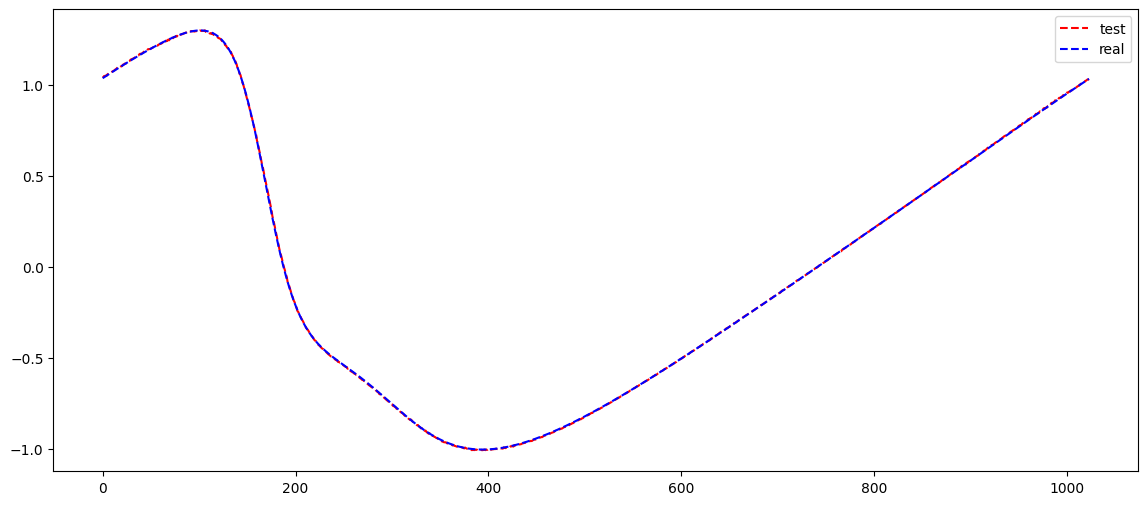

In [346]:
# Larger plot for the profile curve, SAMWO
plt.figure(figsize=(14,6))
plt.plot(mwt_new[-1].detach().cpu(), '--', color="r", label="test")
plt.plot(y_test[-1], '--', color="b", label = "real")
plt.legend()

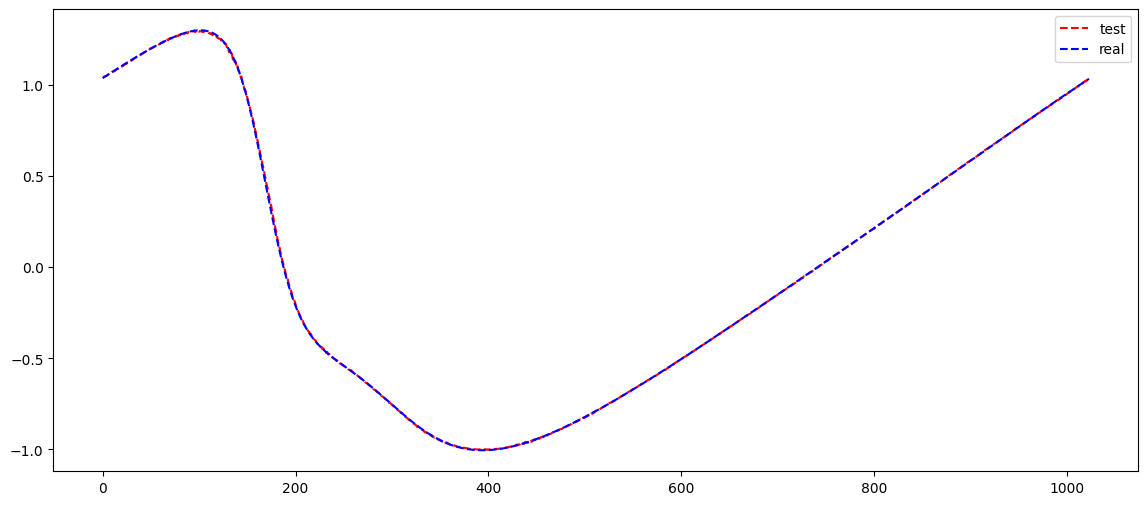

In [347]:
# Smaller plot for the profile curve, MWO
plt.figure(figsize=(14,6))
plt.plot(mwt_org[-1].detach().cpu(), '--', color="r", label="test")
plt.plot(y_test[-1], '--', color="b", label = "real")
plt.legend()

# Signal analysis

Text(0, 0.5, 'Linear spectrum [V RMS]')

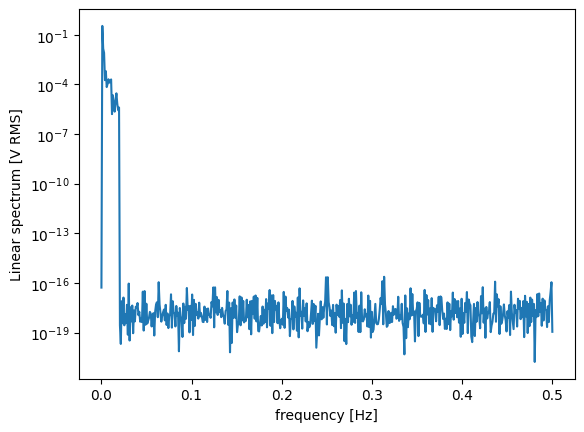

In [205]:
# Periodogram example
# If you use some new dataset, it is recommended to analyze the inputs over frequency domain

f, p = periodogram(x_train[0].detach().numpy().T.squeeze(),1,scaling='spectrum')
plt.semilogy(f,p)
#plt.ylim([1e-5, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')

## Revisiting spectral bias

In [398]:
# Call the frequency data learnt with two models during the training process above
freq_list = np.array(freq_list)
freq_list_org = np.array(freq_list_org)

In [399]:
# Data pre-processing, 0-1 scaling
# If necessary, we can rescale the model by excluding the commonly unlearnt frequency ranges

a = np.copy(freq_list)
b = np.copy(freq_list_org)
for i in range(len(a)):
    X = a[i]
    Y = b[i]
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    Y_std = (Y - Y.min(axis=0)) / (Y.max(axis=0) - Y.min(axis=0))
    a[i] = X_std
    b[i] = Y_std

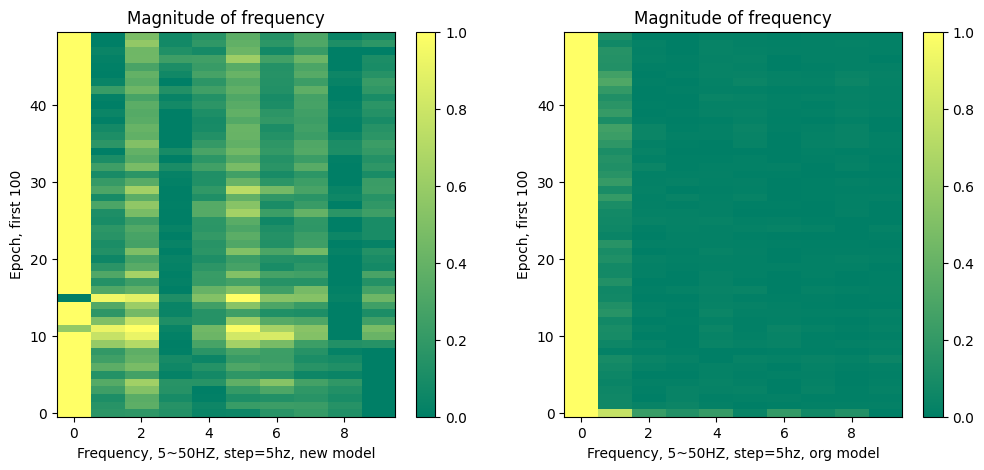

In [418]:
# Plot the figure, left for SAMWO and right for MWO
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
idx= [0,1,2,3,4,5,6,7,8,9] 

im1 = ax0.imshow(np.array(a)[0:50:1,idx],origin='lower',interpolation='none',aspect='auto',cmap = 'summer')
ax0.set_ylabel('Epoch, first 50')
ax0.set_xlabel('Frequency, 5~50HZ, step=5hz, new model')
ax0.set_title('Magnitude of frequency')
plt.colorbar(im1)

im2 = ax1.imshow(np.array(b)[0:50:1,idx],origin='lower',interpolation='none',aspect='auto',cmap = 'summer')
ax1.set_ylabel('Epoch, first 50')
ax1.set_xlabel('Frequency, 5~50HZ, step=5hz, org model')
ax1.set_title('Magnitude of frequency')
plt.colorbar(im2)

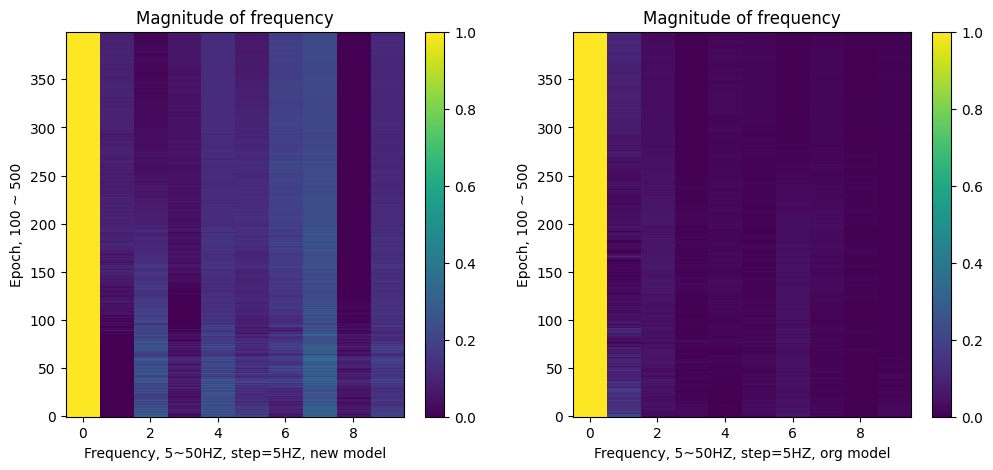

In [423]:
# Normalized, epoch size normalized, frequency levels chosen where the learning actually occurs
# In this way we can compare the models better
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
idx= [0,1,2,3,4,5,6,7,8,9]

im1 = ax0.imshow(a[100:500,idx],origin='lower',interpolation='none',aspect='auto')
ax0.set_ylabel('Epoch, 100 ~ 500')
ax0.set_xlabel('Frequency, 5~50HZ, step=5HZ, new model')
ax0.set_title('Magnitude of frequency')
plt.colorbar(im1)

im2 = ax1.imshow(b[100:500,idx],origin='lower',interpolation='none',aspect='auto')
ax1.set_ylabel('Epoch, 100 ~ 500')
ax1.set_xlabel('Frequency, 5~50HZ, step=5HZ, org model')
ax1.set_title('Magnitude of frequency')
plt.colorbar(im2)

## For simple MLP

In [76]:
# Simple one-layer model
class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=1024, output_size=1, initializer=None):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.LazyLinear(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.LazyLinear(output_size)
        if initializer is not None:
            self.reset_parameters(initializer)
        
    def reset_parameters(self, initializer):
        initializer(self.fc1.weight)
        initializer(self.fc2.weight)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [77]:
# Training
# But this will not actually anything, due to poor performance
import time as time
initializer = get_initializer('xavier_normal')
simple_model = SimpleMLP().to(device)
learning_rate = 0.001

epochs = 100
step_size = 100
gamma = 0.5
optimizer = torch.optim.Adam(simple_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
to_ti = 0
freq_list_simple = []

for epoch in range(1, epochs+1):
    tic = time.time()
    train_l2 = train(simple_model, train_loader, optimizer, epoch, device,
        lossFn = myloss, lr_schedule = scheduler)
    toc = time.time()
    to_ti += toc-tic
    
    # get the frequency 
    pred = simple_model(torch.Tensor(signal.reshape(1,1024,1)).to(device)).detach().cpu()
    g, h= new_fft(pred.squeeze())
    freq_selected = h[np.sum(g.reshape(-1, 1) == frequencies.reshape(1, -1), axis=-1, dtype='bool')]
    norm_dynamics = 2* freq_selected
    freq_list_simple.append(norm_dynamics)

    test_l2 = test(simple_model, test_loader, device, lossFn=myloss)

    print(f'epoch: {epoch}, train l2 = {train_l2}, tr time = {toc-tic} test l2 = {test_l2}')
print(f'total time elapsed {to_ti}s')

c:\Users\lovek\.conda\envs\tf\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch: 1, train l2 = 0.7771260976791382, tr time = 0.35076355934143066 test l2 = 0.7187429761886597
epoch: 2, train l2 = 0.6983615818023682, tr time = 0.26174330711364746 test l2 = 0.7165212535858154
epoch: 3, train l2 = 0.6979621782302856, tr time = 0.26794910430908203 test l2 = 0.7161570835113525
epoch: 4, train l2 = 0.6989362125396729, tr time = 0.2600221633911133 test l2 = 0.7186089849472046
epoch: 5, train l2 = 0.6992760696411133, tr time = 0.26284265518188477 test l2 = 0.7212202167510986
epoch: 6, train l2 = 0.6983649139404297, tr time = 0.26058077812194824 test l2 = 0.7166893577575684
epoch: 7, train l2 = 0.6980121870040894, tr time = 0.26403141021728516 test l2 = 0.7164396810531616
epoch: 8, train l2 = 0.6984944400787354, tr time = 0.259418249130249 test l2 = 0.7164260244369507
epoch: 9, train l2 = 0.698696795463562, tr time = 0.2647063732147217 test l2 = 0.7172656583786011
epoch: 10, train l2 = 0.6989620456695557, tr time = 0.26349520683288574 test l2 = 0.7166440296173096
epoc

In [78]:
# Data pre-processing
freq_list_simple = np.array(freq_list_simple)
c = np.copy(freq_list_simple)

for i in range(len(c)):
    Y = c[i]
    Y_std = (Y - Y.min(axis=0)) / (Y.max(axis=0) - Y.min(axis=0))
    c[i] = Y_std

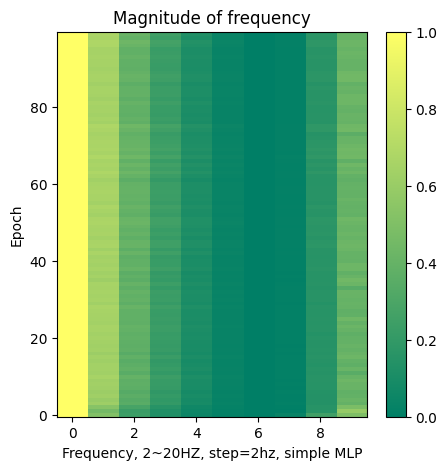

In [201]:
# Plot the frequency domain
fig, ax = plt.subplots(1, figsize=(5,5))
im1= ax.imshow(c, origin='lower',interpolation='none',aspect='auto',cmap = 'summer')
ax.set_ylabel('Epoch')
ax.set_xlabel('Frequency, 2~20HZ, step=2hz, simple MLP')
ax.set_title('Magnitude of frequency')
plt.colorbar(im1)

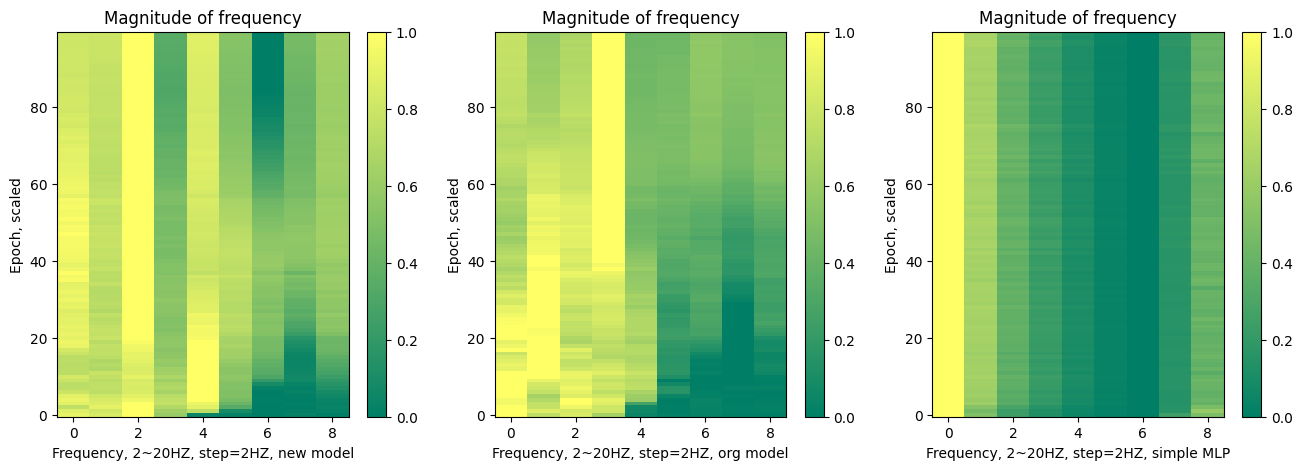

In [200]:
# Normalized, epoch size normalized, frequency levels chosen where the learning actually occur
# In this way we can compare the models better
# 3 model comparison, left: SAMWO, middle: MWO, right: MLP
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(16,5))
idx= [0,1,2,3,4,5,6,8,9]

im1 = ax0.imshow(a[0::5,idx],origin='lower',interpolation='none',aspect='auto',cmap='summer')
ax0.set_ylabel('Epoch, scaled')
ax0.set_xlabel('Frequency, 2~20HZ, step=2HZ, new model')
ax0.set_title('Magnitude of frequency')
plt.colorbar(im1)

im2 = ax1.imshow(b[0::5,idx],origin='lower',interpolation='none',aspect='auto',cmap='summer')
ax1.set_ylabel('Epoch, scaled')
ax1.set_xlabel('Frequency, 2~20HZ, step=2HZ, org model')
ax1.set_title('Magnitude of frequency')
plt.colorbar(im2)

im3= ax2.imshow(c[0::1,idx], origin='lower',interpolation='none',aspect='auto',cmap='summer')
ax2.set_ylabel('Epoch, scaled')
ax2.set_xlabel('Frequency, 2~20HZ, step=2HZ, simple MLP')
ax2.set_title('Magnitude of frequency')
plt.colorbar(im3)